In [1]:
import os
import torch.nn as nn
import torch
from main import Trainer, args_parse
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
opt = args_parse()

trainer = Trainer(opt)

device = trainer.device
model = trainer.model
model.eval()

device, model

('cuda:0',
 SuperSampler(
   (input): Sequential(
     (0): Rearrange('b c (h p0) (w p1) -> b (p0 p1) (c h w)', p0=16, p1=16)
     (1): LayerNorm((27,), eps=1e-05, elementwise_affine=True)
     (2): Linear(in_features=27, out_features=2304, bias=True)
     (3): Linear(in_features=2304, out_features=2304, bias=True)
     (4): LayerNorm((2304,), eps=1e-05, elementwise_affine=True)
   )
   (embed): PosEmbedBlock(
     (block): Sequential(
       (0): Linear(in_features=2304, out_features=2304, bias=True)
       (1): Linear(in_features=2304, out_features=2304, bias=True)
       (2): Dropout(p=0.5, inplace=True)
     )
   )
   (msa): ModuleList(
     (0-15): 16 x MSA(
       (norm): LayerNorm((2304,), eps=1e-05, elementwise_affine=True)
       (q): Linear(in_features=2304, out_features=32, bias=True)
       (k): Linear(in_features=2304, out_features=32, bias=True)
       (v): Linear(in_features=2304, out_features=32, bias=True)
     )
   )
   (mhp): Sequential(
     (0): Linear(in_features=

In [25]:
sample_down, sample_up = iter(trainer.dataloader).__next__()
sample_down = sample_down.to(trainer.device)
sample_up = sample_up.to(trainer.device)

model.input, sample_down.shape

(Sequential(
   (0): Rearrange('b c (h p0) (w p1) -> b (p0 p1) (c h w)', p0=16, p1=16)
   (1): LayerNorm((27,), eps=1e-05, elementwise_affine=True)
   (2): Linear(in_features=27, out_features=2304, bias=True)
   (3): Linear(in_features=2304, out_features=2304, bias=True)
   (4): LayerNorm((2304,), eps=1e-05, elementwise_affine=True)
 ),
 torch.Size([32, 3, 48, 48]))

In [113]:
# extract qk to show self-attention score.
def get_msa_color_map(img_idx, msa_idx):
    x = sample_down[img_idx:img_idx+1]
    x = model.input(x)
    x = model.embed(x)
    x = model.msa[msa_idx].norm(x)

    q = model.msa[msa_idx].q(x)
    k = model.msa[msa_idx].k(x)
    qk = torch.matmul(q, k.transpose(1,2))
    
    for i in range(256):
        qk[0][i][i] = 0.0

    score = torch.softmax(qk, dim=2)
    score = torch.sum(score, dim=1)
    score = score.view(1, 16, 16)
    score = score.repeat_interleave(3, dim=1)
    score = score.repeat_interleave(3, dim=2)
    score = torch.clamp(score, 0.0, 1.0)

    color_map = torch.cat([torch.zeros((2, 48, 48), device=device), score], dim=0)

    img = (sample_down[img_idx]*0.5+0.5) + color_map
    img = torch.clamp(img, 0.0, 1.0)

    return img.cpu().detach()

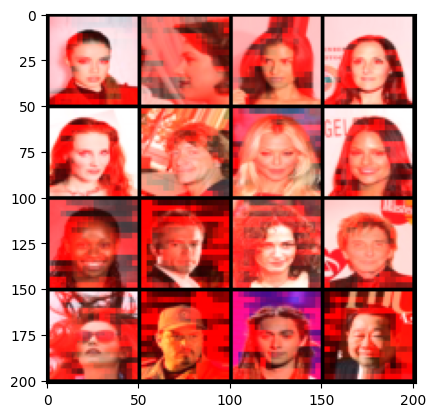

In [131]:
img = [get_msa_color_map(i, 15) for i in range(16)]
img = make_grid(img, nrow=4)
plt.imshow(img.permute(1,2,0))